In [2]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379373 sha256=6ac7ccada7eb26af440c9a7d2424acd870fe58b16c9c77dfc3f6c8dd3509df45
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import collections
from dataclasses import dataclass
from tqdm import tqdm

import argparse
import time
from torch.utils.tensorboard.writer import SummaryWriter
import matplotlib.pyplot as plt

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

print(device)

cuda


In [3]:
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [4]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
State = np.ndarray
Action = int

@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done: bool
    new_state: State

class ReplayBuffer:
  def __init__(self, capacity : int):
    self.buffer = collections.deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size : int):
    indices = np.random.choice(len(self), batch_size, replace = False)
    return [self.buffer[idx] for idx in indices]

class Agent:
  def __init__(self, env, exp_buffer):
    self.env = env
    self.exp_buffer = exp_buffer
    self.state = None
    self._reset()
    self.total_step = 0

  def _reset(self):
    self.state, _ = self.env.reset()
    self.total_reward = 0.0

  @torch.no_grad()
  def play_step(self, net: DQN, epsilon, device):
    done_reward = None
    self.total_step +=1
    if np.random.random() < epsilon:
      action = self.env.action_space.sample()
    else:
      state_v = torch.as_tensor(self.state).to(device)
      q_values_v = net(state_v)
      action = torch.argmax(q_values_v).item()

    new_state, reward, terminated, truncated, _ = self.env.step(action)
    self.total_reward += reward

    exp = Experience(state = self.state,
                     action = action,
                     reward = reward,
                     done = terminated,
                     new_state = new_state)

    self.exp_buffer.append(exp)
    self.state = new_state

    if terminated or truncated:
      done_reward = self.total_reward
      self._reset()
    return done_reward

def caculate_loss(batch_data: Experience, net, tgt_net, device: torch.device):
  states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch_data, device)

  state_action_values = net(states_t).gather(
      1, actions_t.unsqueeze(-1)
      ).squeeze(-1)

  with torch.no_grad():
    next_state_values = tgt_net(new_states_t).max(1)[0]
    next_state_values[dones_t] = 0.0
    next_state_values = next_state_values.detach()

  expected_state_action_values = next_state_values * GAMMA + rewards_t
  return nn.MSELoss()(state_action_values, expected_state_action_values)


def batch_to_tensors(batch: Experience, device: torch.device):
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done)
        new_state.append(e.new_state)

    states_t = torch.as_tensor(states, device=device, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, device=device, dtype=torch.int64)
    rewards_t = torch.as_tensor(rewards, device=device, dtype=torch.float32)
    dones_t = torch.as_tensor(dones, dtype=torch.bool, device=device)
    new_state_t = torch.as_tensor(new_state, device=device, dtype=torch.float32)
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), dones_t.to(device), new_state_t.to(device)


In [12]:
# hyperparameters
# BELLMAN EQUATION
GAMMA = 0.99

# ACTION HYPER
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995

# TRAINING & MEMORY
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 100000
LEARNING_RATE = 5e-4
SYNC_TARGET_FRAMES = 10

MAX_STEPS = 1000 
frame_idx = 0

episodes = 1000
solved_reward = 200

In [13]:
# Initialize
buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START
loss_list = []
rewards_list = []
avg_loss_list= []
net = DQN(state_dim, action_dim).to(device)
tgt_net = DQN(state_dim, action_dim).to(device)
tgt_net.load_state_dict(net.state_dict())
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

for episode in tqdm(range(episodes), desc="Training Progress"):
    state, _ = env.reset()
    total_reward = 0
    episode_loss = 0
    loss_steps = 0

    for step in range(MAX_STEPS):
        frame_idx += 1
        reward = agent.play_step(net, epsilon, device)

        if reward is not None:
            total_reward += reward

        if len(buffer) >= BATCH_SIZE:
            batch = buffer.sample(BATCH_SIZE)
            loss_t = caculate_loss(batch, net, tgt_net, device)
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
            loss_list.append(loss_t.item())
            episode_loss += loss_t.item()
            loss_steps += 1

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        if agent.exp_buffer.buffer[-1].done:
            break

    rewards_list.append(total_reward)

    if len(rewards_list) >= 100:
      avg_reward = sum(rewards_list[-100:]) / 100
      if avg_reward >= solved_reward:
        print(f"\nSolved in {episode} episodes, agent use {agent.total_step} to solve problem!")
        break

    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    if loss_steps > 0:
      avg_loss = episode_loss / loss_steps
      avg_loss_list.append(avg_loss)
    else:
      avg_loss_list.append(0.0)

    if episode % 100 == 0:
        avg_r = np.mean(rewards_list[-50:])
        print(f"\nEpisode {episode}, avg reward (last 50): {avg_r:.2f}, epsilon: {epsilon:.3f}")

Training Progress:   0%|          | 2/1000 [00:00<01:58,  8.42it/s]


Episode 0, avg reward (last 50): -97.33, epsilon: 0.995


Training Progress:  10%|█         | 101/1000 [00:31<08:15,  1.81it/s]


Episode 100, avg reward (last 50): -82.83, epsilon: 0.603


Training Progress:  20%|██        | 201/1000 [03:06<24:49,  1.86s/it]


Episode 200, avg reward (last 50): -34.29, epsilon: 0.365


Training Progress:  30%|███       | 301/1000 [09:58<44:46,  3.84s/it]


Episode 300, avg reward (last 50): 64.08, epsilon: 0.221


Training Progress:  40%|████      | 401/1000 [15:36<29:37,  2.97s/it]


Episode 400, avg reward (last 50): 190.94, epsilon: 0.134


Training Progress:  45%|████▍     | 449/1000 [17:34<21:33,  2.35s/it]


Solved in 449 episodes, agent use 207036 to solve problem!


In [14]:
torch.save(net.state_dict(), "lunar_lander_dqn.pth")

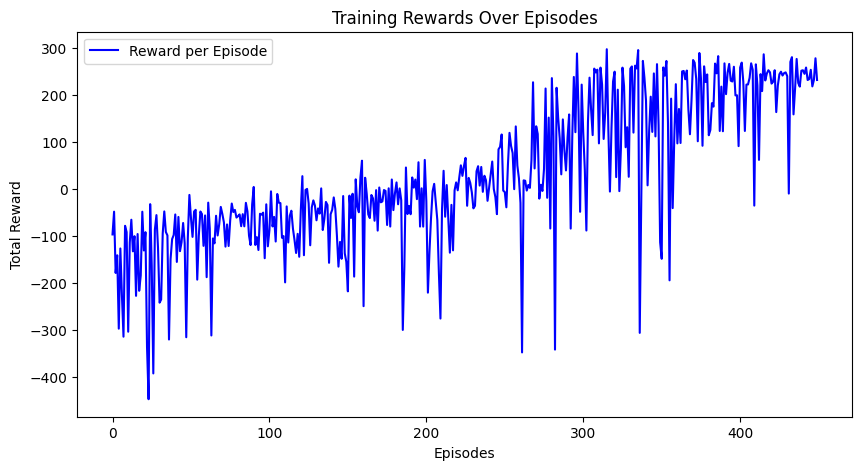

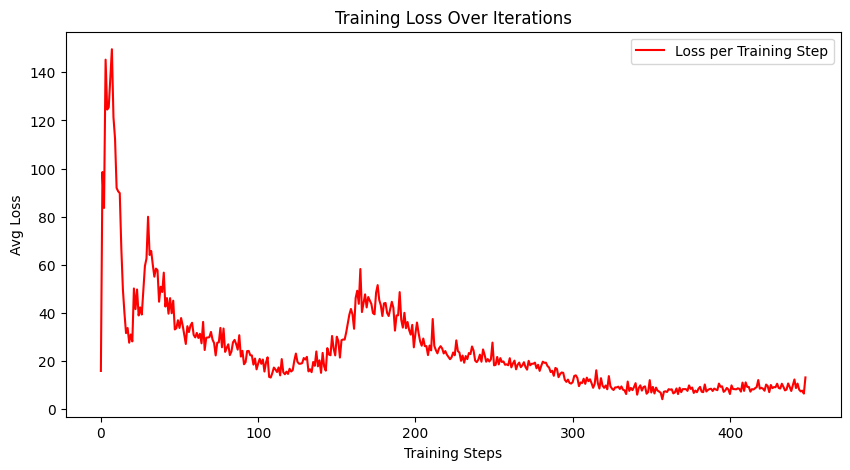

In [15]:

plt.figure(figsize=(10, 5))
plt.plot(rewards_list, label="Reward per Episode", color='blue')
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Training Rewards Over Episodes")
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(avg_loss_list, label="Loss per Training Step", color='red')
plt.xlabel("Training Steps")
plt.ylabel("Avg Loss")
plt.title("Training Loss Over Iterations")
plt.legend()
plt.show()

In [16]:
import gymnasium as gym
import torch
import imageio

env = gym.make("LunarLander-v3", render_mode="rgb_array")
net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
net.load_state_dict(torch.load("lunar_lander_dqn.pth", map_location=device))
net.eval()
state, _ = env.reset()

frames = []
for _ in range(1000):
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    action = torch.argmax(net(state)).item()
    next_state, reward, done, truncated, _ = env.step(action)

    frames.append(env.render())
    state = next_state

    if done:
        break

env.close()

imageio.mimsave("lunar_lander_dqn.gif", frames, fps=30)
print("GIF saved as 'lunar_lander_dqn.gif'!")

GIF saved as 'lunar_lander_dqn.gif'!
